In [14]:
#!pip install h3
#!pip install branca
#!pip install geojson
#!pip install geopandas
#!pip install backoff
#!pip install overpy
#!pip install folium
#!pip install OSMPythonTools
#!pip install wordcloud
import json
import branca.colormap as cm
from geojson import Feature, Point, FeatureCollection
from geopandas.tools import sjoin
from h3 import geo_to_h3, h3_to_geo_boundary
from shapely.geometry import Polygon
import seaborn as sns
from utils_spatial import *

# Description

The purpose of this use case is to show a replicable social coverage analysis.

# Instructions
The next steps were followed:

- Define an amenity of interest and a country of interest.
- OpenStreetMaps is used (if official information is not available) as a source to collect each amenity and its georeference.
- Define a transport profile ('driving', 'walking') and a time profile (15 m, 30 m, etc).
- Use the mapbox API (https://datapartnership.org/) to calculate isochrons for each georeference - profile and desired time. 
- Define a population layer of interest using the Facebook project - High resolution population density map (women_of_reproductive_age_15_49, etc).
- Generate hexagons to simplify analysis.
- Perform spatial join to identify the population without access to the service with the defined profile.

## Parameters definition

In [15]:
# Country and Amenity
###########################
amenities = ['hospital']
path = '_'.join(amenities)
if len(amenities)==1 :
    amenity =amenities
isoalpha3 = 'GUY' # GTM

# Transportation profile
###########################
profile='driving'
time_profiles=[45]
minute = time_profiles[0]

# Population of interest
###########################
population_='women_of_reproductive_age_15_49'

## Get amenity from OSM

In [16]:
countries = pd.read_excel(scldatalake + 'Manuals and Standards/IADB country and area codes for statistical use/IADB_country_codes_admin_0.xlsx', engine='openpyxl')
amenities_iso = pd.read_csv(scldatalake + f'Geospatial infrastructure/Healthcare Facilities/healthcare_facilities.csv', low_memory=False)
amenities_iso = amenities_iso[amenities_iso.isoalpha3 == isoalpha3].reset_index(drop=True)

358


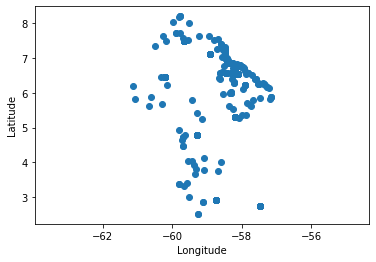

In [17]:
plot_lat_lon(amenities_iso)
#amenities_iso.to_csv('amenities.csv')


## Get isochrones

In [ ]:
%%capture
project_name = f'{isoalpha3}_{amenity}' 
isochrones_data = create_isochrone_analysis(data = amenities_iso, project_name=project_name,
                                            output_folder='../data', token=access_token, 
                                            profile=profile, time_profiles=time_profiles)

In [ ]:
plot_isochone_points(facility_data=amenities_iso, isochrones_data=isochrones_data, zoom_start=10, geom='FeatureCollection')

## Get Population layers

In [ ]:
population = pd.read_csv(scldatalake + 
                         f'Development Data Partnership/Facebook - High resolution population density map/public-fb-data/csv/{isoalpha3}/{isoalpha3}_{population_}.csv.gz',
                        sep='\t').rename(columns={'latitude':'lat', 'longitude':'lon'})
population["hex_id"] = population.apply(lambda x: geo_to_h3(x["lat"], x["lon"], 8), axis=1)
population_8 = population.groupby('hex_id').agg({'population':sum}).reset_index()
population_8['hex'] = population_8['hex_id'].apply(lambda x: h3_to_geo_boundary(x, geo_json=True))
population_8['hex_poly'] = population_8['hex'].apply(lambda x: Polygon(x))
gs = gpd.GeoSeries(population_8['hex_poly'])
gdf = gpd.GeoDataFrame(population_8, geometry=gs, crs="EPSG:4326")

gdf.plot( figsize=(9, 9), column='population', cmap='inferno');

In [ ]:
population.population.sum()

In [ ]:
gdf.population.sum()

In [ ]:
#isochrones_data

In [ ]:
#%%capture
isochrone = isochrones_data[isochrones_data.minutes == minute].reset_index()
#geom = gpd.GeoDataFrame.from_features(isochrone['geometry'][0])
geom = gpd.GeoDataFrame(isochrone, geometry='multipolygon')
#isochrone

geom[f'geom_{minute}'] = True
#gdf_match = sjoin(gdf, geom[[f'geom_{minute}', 'amenity', 'geometry']], how='left')

In [ ]:
#geom.plot()
geom[f'geom_{minute}'] = True
gdf_match = sjoin(gdf, geom[[f'geom_{minute}', 'amenity', 'multipolygon']], how='left')
gdf_match.population.sum()

In [ ]:
#isochrone
gdf_match.loc[(gdf_match[f'geom_{minute}'].isna()), f'geom_{minute}'] = False
gdf_match.loc[(gdf_match.amenity.isna()), 'amenity'] = 'False'
del gdf_match['geometry']
gdf_match = gdf_match.rename(columns={'hex':'geometry'})
get_geom = gdf_match[gdf_match[f'geom_{minute}']==False]
get_geom['value'] = np.log(get_geom.population)
get_geom.loc[(get_geom['value']<0),'value']=0

hex_name = 'hex_id'
column_name = 'value'
list_features = []
for i,row in get_geom.iterrows():
    feature = Feature(geometry = row["hex_poly"] , id=row["hex_id"], properties = {"value" : row[column_name]})
    list_features.append(feature)
    
feat_collection = FeatureCollection(list_features)
geojson_result = json.dumps(feat_collection)


En un escenario de 30 minutos ### personas no tienen acceso a un servicio de ###

## Final Map

In [3]:
min_value = min(get_geom.value)
max_value = max(get_geom.value)


custom_cm = cm.LinearColormap(['yellow', 'red'], vmin=min_value, vmax=max_value)
custom_cm = cm.LinearColormap(['yellow', 'red'], vmin=min_value, vmax=max_value)

lat_mean = np.mean(population['lat'])
lon_mean = np.mean(population['lon'])

m = folium.Map(location=[lat_mean,lon_mean], zoom_start=10, tiles='CartoDB positron')

folium.GeoJson(geojson_result,
        style_function=lambda feature: {
            'fillColor': custom_cm(feature['properties']['value']),
            'color': 'black',
            'weight': .001, 
            'weight': 1,
            'fillOpacity': .7 
        }, 
        name ='temp').add_to(m)



color = ['green']
for i, x in isochrone.iterrows():
    fillColor = color[i]
    folium.GeoJson(data=x['FeatureCollection'], name=x['profile'],
                   style_function=lambda x,
                   fillColor=fillColor, color=fillColor: {
                       "fillColor": fillColor,
                        'weight': 2,
                        'opacity': 1,
                        'color': 'black',
                        'weight': .01, 
                        'fillOpacity': 0.7
                   }).add_to(m)
m

NameError: name 'get_geom' is not defined

In [ ]:
gdf_match.loc[gdf_match.amenity=='hospital', 'amenity'] = 'covered'
gdf_match.loc[gdf_match.amenity=='False', 'amenity'] = 'uncovered'
pd.options.display.float_format = '{:.2f}'.format
out = gdf_match.groupby(['amenity'])['population'].sum().reset_index()
out['pct'] = out.population/out.population.sum()*100
out

In [ ]:
level='2'
#world = gpd.read_file(scldatalake +
#                      'Geospatial Basemaps/Cartographic Boundary Files/world/level-1/world-level-1.zip')
#world = world.rename(columns={"GID_0":"isoalpha3", 'NAME_1':'admin_name'})
#country = world[world.isoalpha3=='GUY'].reset_index(drop=True)

#del gdf_match['index_right']
gdf_match['geometry'] = gdf_match['hex_poly'].copy()
test = sjoin(country, gdf_match, how='left')
level_1 = test.groupby(['admin_name', 'amenity'])['population'].sum().reset_index()
t = level_1.groupby(['admin_name'])['population'].sum().reset_index().rename(columns={'population':'poptot'})
level_1 = level_1.merge(t, on='admin_name', how='left')
level_1['pct'] = level_1.population/level_1.poptot*100
level_1 = level_1[level_1.amenity=='underserved'].sort_values('population', ascending=False)

In [ ]:
level_1.sort_values('pct', ascending=False)

In [ ]:
ax = sns.barplot(y="admin_name", x="population", data=level_1.head(10), palette="Blues_d")
ax

In [ ]:
#!pip install mapclassify
import mapclassify

country_result = country.merge(level_1, on='admin_name', how='left')
fig, ax = plt.subplots(1, figsize=(10, 6))
country_result.plot( figsize=(9, 9), column='pct', 
                    ax=ax, 
                    scheme='QUANTILES', k=10, 
                     cmap='BuPu', legend=True,
                     legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5),  'fmt':"{:.0f}"})
ax.set_title(f'Percentage of population without coverage - Level 1 {amenity} + {profile} + {time_profiles} min')